In [0]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import copy
import numpy as np

**BLOCK PREPROCESSING**

In [0]:
def closest_tag (code_block, tag_arr, pos):
    closest = -1
    for i in range(len(tag_arr) - 1):
        if (tag_arr[i] < code_block and tag_arr[i + 1] > code_block):
            closest = i
            break
    if pos == 'end':
        closest += 1
    return tag_arr[closest]

In [0]:
def tag_preproc(tag_arr):
    for i in range(len(tag_arr)):
        tag_arr[i] = tag_arr[i].lower()
        tag_arr[i] = re.sub(r'[^a-z0-9\s]', '', tag_arr[i])
        # tag_arr[i] = tag_arr[i].replace(' ', '_') #   ????????????
        try:
            if tag_arr[i][0] == ' ':
                tag_arr[i][0] = ''
        except:
            pass

In [0]:
def block_preproc(blocks_arr, key, block_type):
    if block_type == 'code':
        too_many_ns = r'\\n' * 10
        for i in range(len(blocks_arr)):
            if too_many_ns in blocks_arr[i]:
                blocks_arr[i] = ''
    elif block_type == 'tag':
        for i in range(len(blocks_arr)):
            if 'https://' in blocks_arr[i]:
                if i == 0:
                    for j in range(i, len(blocks_arr)):
                        if 'https://' in blocks_arr[j]:
                            continue
                        else:
                            blocks_arr[i] = blocks_arr[j]
                            break
                else:
                    blocks_arr[i] = blocks_arr[i - 1]

    for i in range(len(blocks_arr)):
        blocks_arr[i] = re.sub(r'\\\\\\u0022|\\u0027', "'", blocks_arr[i])
        blocks_arr[i] = re.sub(r'\\u....', '', blocks_arr[i])
        blocks_arr[i] = re.sub(r'\\\\n', '\n', blocks_arr[i])
        blocks_arr[i] = re.sub(r'\\', '', blocks_arr[i])
        blocks_arr[i] = re.sub(key, '', blocks_arr[i])

        if block_type == 'tag':
            blocks_arr[i] = blocks_arr[i].lower()
            blocks_arr[i] = re.sub(r'[^a-z0-9\s]', '', blocks_arr[i])
            # blocks_arr[i] = blocks_arr[i].replace(' ', '_') #   ????????????

    

In [0]:
def comment_finder(text):
    if text[-1] != '\n':
      text += '\n'
    comments = []
    line_end = [i for i in range(len(text)) if text.startswith('\n', i)]
    try:
        if text[0] == '#':          # text is non-empty by the condition before running
            comments.append(text[0:line_end[0]])
    except: #let's add a try-pass in case there is a code block with just 1 comment
        pass

    comments_begin = [(i) for i in range(len(text)) if text.startswith('#', i)]
    comments_end = []
    try:
        for i in range(len(comments_begin)):
            comments_end.append(closest_tag(comments_begin[i], line_end, pos='end'))
    except:
        pass

    try:
        for i in range(len(comments_begin)):
            comments.append(text[comments_begin[i] : comments_end[i]])
    except:
        pass

    no_preproc = copy.deepcopy(comments)
    tag_preproc(comments)
    return comments, no_preproc


**NOTEBOOK PARSING**

In [0]:
def notebook_parse (link):
    key_begin = r'\u0022cell_type\u0022:\u0022code\u0022,\u0022source\u0022:'   # \u0022execution_count\u0022:,\u0022outputs\u0022:[]
    key_end = r'\u0022execution_count\u0022:'#((null)|\d{1}),\u0022outputs\u0022:[]'
    tag_key_begin = r'\u0022cell_type\u0022:\u0022markdown\u0022,\u0022source\u0022:'
    tag_key_end = r'},{\u0022metadata\u0022:{'
    key = '@@@@'
    
    r = requests.get('https://www.kaggle.com/' + link) # 'https://www.kaggle.com/roshansharma/amazon-alexa-reviews'

    soup = BeautifulSoup(r.text, 'html.parser')
    scripts = soup.find_all('script')

    blocks = []
    tags = []

    for scr in scripts:
        test_str = scr.text

        if (key_begin in test_str) and (key_end in test_str):
            #   finding code blocks ---------------------------------------
            res_begin = [i for i in range(len(test_str)) if test_str.startswith(key_begin, i)] 
            res_end = [i for i in range(len(test_str)) if test_str.startswith(key_end, i)]

            try:
                for i in range(min(len(res_begin), len(res_end))):
                    blocks.append(test_str[res_begin[i] : res_end[i]])
            except:
                pass

            blocks = list(dict.fromkeys(blocks))
            length = len(blocks)
            res_begin = res_begin[:length]
            res_end = res_end[:length]
            #   finding tags ---------------------------------------
            tags_begin_ = [i for i in range(res_end[-1]) if test_str.startswith(tag_key_begin, i)]
            
            tags_begin = []
            try:
                for i in range(len(res_begin)):
                    tags_begin.append(closest_tag(res_begin[i], tags_begin_, pos = 'begin'))
            except:
                pass

            tags_end_ = [i for i in range(res_end[-1]) if test_str.startswith(tag_key_end, i)]
            
            tags_end = []
            try:
                for i in range(len(tags_begin)):
                    tags_end.append(closest_tag(tags_begin[i], tags_end_, pos='end'))
            except:
                pass

            try:
                for i in range(len(tags_begin)):
                    if tags_end[i] < tags_begin[i] and i != len(tags_begin) - 1:
                        tags_end[i] = tags_end[i + 1]
                    tags.append(test_str[tags_begin[i] : tags_end[i]])
            except:
                pass

    block_preproc(blocks, key = r'cell_type:code,source:', block_type = 'code')
    block_preproc(tags, key = r'cell_type:markdown,source:', block_type = 'tag')

    code_block = pd.Series(blocks, name='code_block')
    tag = pd.Series(tags, name='tag')
    out = pd.concat([code_block, tag], axis=1).fillna(key)

    for i in range(len(blocks)):
        if '#' in blocks[i]:
          comments, no_preproc_comments = comment_finder(blocks[i])
          if len([x for x in str(out.loc[i, 'tag']).split()]) < 10:
            comments.append(out.loc[i, 'tag'])
          
          try:
            comments.remove(key)
          except ValueError:
            pass
          
          if comments == []:
            out.at[i, 'tag'] = np.nan
          else:
            out.at[i, 'tag'] = list(dict.fromkeys(comments))
          for comment in no_preproc_comments:
            out.at[i, 'code_block'] = out.loc[i, 'code_block'].replace(comment, '')

        if out.loc[i, 'tag'] == key or out.loc[i, 'tag'] == [key] or out.loc[i, 'tag'] == [''] or out.loc[i, 'tag'] == ' ':
          out.at[i, 'tag'] = np.nan
          # TO DO - add the same for code

    out['code_block'] = out['code_block'].apply(lambda text: re.sub(r"(\n)\1+", '\n', text))

    return out.dropna().reset_index(drop=True)


In [0]:
df_1 = pd.read_csv('/content/kaggle_kernels_hotness.csv')
df_2 = pd.read_csv('/content/kaggle_kernels_scoreAscending.csv')
df_3 = pd.read_csv('/content/kaggle_kernels_scoreDescending.csv')
df_4 = pd.read_csv('/content/kaggle_kernels_voteCount.csv')
df_5 = pd.read_csv('/content/kaggle_kernels_commentCount.csv')
df_6 = pd.read_csv('/content/kaggle_kernels_viewCount.csv')
df_7 = pd.read_csv('/content/kk_2_4_2020.csv')
df_8 = pd.read_csv('/content/kk_4_4_2020.csv')
df_9 = pd.read_csv('/content/kk_6_4_2020.csv')
df_10 = pd.read_csv('/content/kk_8_4_2020.csv')
df_11 = pd.read_csv('/content/kk_10_4_2020.csv')
df_12 = pd.read_csv('/content/kk_12_4_2020.csv')
df_13 = pd.read_csv('/content/kk_14_4_2020.csv')
df_14 = pd.read_csv('/content/kk_16_4_2020.csv')
df_15 = pd.read_csv('/content/kk_18_4_2020.csv')
df_16 = pd.read_csv('/content/kk_20_4_2020.csv')
df_17 = pd.read_csv('/content/kk_22_4_2020.csv')
df_18 = pd.read_csv('/content/kk_25_4_2020.csv')
df_19 = pd.read_csv('/content/kk_28_4_2020.csv')
df_20 = pd.read_csv('/content/kk_30_4_2020.csv')
df_21 = pd.read_csv('/content/kk_4_5_2020.csv')
df_22 = pd.read_csv('/content/kk_6_5_2020.csv')


in_df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10, 
                  df_11, df_12, df_13, df_14, df_15, df_16, df_17, df_18, df_19, df_20, df_21, df_22])

in_df.drop_duplicates(subset = 'ref', inplace = True)
in_df.sort_values(by = 'totalVotes', inplace = True, ascending = False)
in_df = in_df.reset_index(drop=True)

print(len(in_df), 'kernels in total')

in_df.to_csv('/content/drive/My Drive/all_kernels.csv', sep='\t', encoding='utf-8')

17500 kernels in total


In [0]:
res = []
log = []
kernels = in_df.iloc[:, 0]
empty_counter = 0

for i in range(len(kernels)):
    start_time = time.time()
    try:
      res.append(notebook_parse(kernels[i]))
    except:
      pass
    end_time = time.time()
    if (len(notebook_parse(kernels[i])) == 0):
      empty_counter += 1
    log.append(len(res[-1]))
    print("notebook: # "+str(i)+'\t'+"number of code blocks: "+str(log[-1])+'\t'+"time: "+str(end_time - start_time))

notebook: # 0	number of code blocks: 32	time: 1.6149561405181885
notebook: # 1	number of code blocks: 25	time: 0.4538753032684326
notebook: # 2	number of code blocks: 52	time: 0.48992371559143066


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Streaming output truncated to the last 5000 lines.
notebook: # 12501	number of code blocks: 4	time: 0.3680238723754883
notebook: # 12502	number of code blocks: 18	time: 0.24506044387817383
notebook: # 12503	number of code blocks: 5	time: 0.3055286407470703
notebook: # 12504	number of code blocks: 32	time: 0.321666955947876
notebook: # 12505	number of code blocks: 48	time: 0.294750452041626
notebook: # 12506	number of code blocks: 23	time: 0.32810091972351074
notebook: # 12507	number of code blocks: 35	time: 0.25644850730895996
notebook: # 12508	number of code blocks: 5	time: 0.31358790397644043
notebook: # 12509	number of code blocks: 33	time: 0.36800241470336914
notebook: # 12510	number of code blocks: 37	time: 0.2999238967895508
notebook: # 12511	number of code blocks: 29	time: 0.3241086006164551
notebook: # 12512	number of code blocks: 10	time: 0.22789907455444336
notebook: # 12513	number of code blocks: 32	time: 0.6784853935241699
notebook: # 12514	number of code blocks: 7	time: 0.

In [21]:
print(empty_counter * 100 / len(kernels))

8.097142857142858


In [36]:
log = pd.Series(log)
log.describe()

count    17500.000000
mean        15.711371
std         20.450405
min          0.000000
25%          4.000000
50%          7.000000
75%         21.000000
max        276.000000
dtype: float64

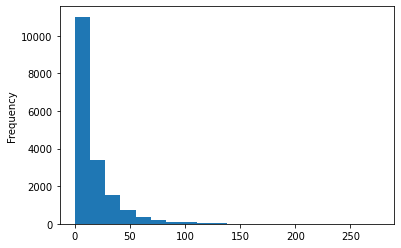

In [37]:
%matplotlib inline

log.plot.hist(bins=20)

In [0]:
out_df = pd.concat(res)

In [0]:
out_df = out_df[out_df['code_block'].astype(bool)]
out_df = out_df[out_df['tag'].astype(bool)]

In [40]:
print(len(out_df['code_block']))
# out_df['code_block'].to_csv('/content/drive/My Drive/blocksss.csv', sep='\t', encoding='utf-8', index=False)

270661


In [0]:
out_df.to_csv('/content/drive/My Drive/code_blocks.csv', sep='\t', encoding='utf-8', index=False)

In [0]:
# empty_code = []
# for i in range(len(out_df)):
#   if out_df.iloc[i, 0] == ' ':
#     print(1)
#   elif out_df.iloc[i, 0] == '':
#     print(2)

#   #  or out_df.iloc[i, 0] == '' or out_df.iloc[i, 0] == [''] or out_df.iloc[i, 0] == [' ']:
#   #   empty_code.append(i)
#   #   print(i, out_df.iloc[i, 0])

In [0]:
# print(len(out_df))
# print(out_df[out_df['code_block'] == ' '].index)
# # out_df.drop(, inplace=True)
# print(len(out_df))

In [44]:
all_code = ''

for i in range(len(out_df)):
  code = out_df.iloc[i, 0]
  if code[0] == '\n':
    code = code.replace('\n', '', 1)
  try:
    if code[-1] != '\n':
      code += '\n'
  except:
    pass
  # if code[-1] != '\n':
  #     code += '\n'
      
  all_code += code

print(len(all_code))

101361810


In [45]:
line_ends = [i for i in range(len(all_code)) if all_code.startswith('\n', i)]
print(len(line_ends))
cnt_30 = 0
chunks_30 = []
for i in range(len(line_ends)):
  cnt_30 += 1
  if cnt_30 < 30:
    continue
  else:
    cnt_30 = 0
    chunks_30.append(all_code[line_ends[i - 29] + 1: line_ends[i]])

2287300


In [0]:
pd.DataFrame(data={'code': chunks_30}).to_csv('/content/drive/My Drive/chunks_30.csv', sep='\t', encoding='utf-8', index=False)

In [0]:
#            RUN BEFORE PARSING
# to_drop = []
# for i in range(len(df)):
#     if df.iloc[i, 0] == 'ref':
#         to_drop.append(i)

# df.drop(index=to_drop, inplace=True)
# df.reset_index(inplace=True)

# df.to_csv(file_path, sep='\t', index=False, encoding='utf-8')